# Covid Dataset

**Required Dataset features and target**

The dataset has 53 columns; 1 to represent the country, 1 to represent the day (it will be an integer), 50 floats to represent the positive cases of the 50 previous days, and 1 column to represent the output that is the average of a full week of cases.

![required_features.jpg](https://drive.google.com/uc?id=1smUwSHRwMT8h-M8kjG3ymmxdhQbe1HvY)


In [1]:
# CHANGED BY ASC.

# Installing Incremental learner: Scikit-Multiflow
!pip install scikit-multiflow
!gdown https://drive.google.com/uc?id=1f5GgBqjAsTUFnubHODmfqn6qiNyDBqIw
!unzip /content/src.zip -d /content/src
!cp -r /content/src/src /content/
!rm -r /content/src/src

# Creating a seperate directory to store all csv's
! mkdir -p /content/csv_files
! mkdir -p /content/csv_files/processed_null
! mkdir -p /content/csv_files/processed
! mkdir -p /content/Result/exp1
! mkdir -p /content/Result/exp2
! mkdir -p /content/Result/exp1/runtime
! mkdir -p /content/Result/exp2/runtime
! mkdir -p /content/Result/exp1/summary
! mkdir -p /content/Result/exp2/summary
# Download the zip file
"""
!zip -r /content/file.zip /content/csv_files
from google.colab import files
files.download("/content/file.zip")
"""

     |████████████████████████████████| 1.1MB 4.2MB/s 
Downloading...
From: https://drive.google.com/uc?id=1f5GgBqjAsTUFnubHODmfqn6qiNyDBqIw
To: /content/src.zip
100% 26.1k/26.1k [00:00<00:00, 46.2MB/s]
Archive:  /content/src.zip
  inflating: /content/src/src/_classification_performance_evaluator.py  
  inflating: /content/src/src/base_evaluator.py  
  inflating: /content/src/src/constants.py  
  inflating: /content/src/src/evaluate_prequential.py  
  inflating: /content/src/src/evaluation_data_buffer.py  
  inflating: /content/src/src/measure_collection.py  


'\n!zip -r /content/file.zip /content/csv_files\nfrom google.colab import files\nfiles.download("/content/file.zip")\n'

In [2]:
#!pip uninstall keras
#!pip uninstall tensorflow

!pip install keras==2.3.1
!pip install tensorflow==2.1.0

     |████████████████████████████████| 378kB 5.3MB/s 
     |████████████████████████████████| 51kB 5.3MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 421.8MB 29kB/s 
     |████████████████████████████████| 450kB 40.2MB/s 
     |████████████████████████████████| 3.9MB 38.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=38fe88d1ece496ef5283316f55a0219f1f4a2deb50174e3d925f080688bd87f7
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: gast 0.3.3
    Uninsta

In [3]:
# General Imports 
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')
import glob
import matplotlib.pyplot as plt
import matplotlib

# Imports for incremental learner
from skmultiflow.data import DataStream
from skmultiflow.trees import HoeffdingTreeRegressor
from src.evaluate_prequential import EvaluatePrequential
from skmultiflow.meta import AdaptiveRandomForestRegressor
from skmultiflow.trees import HoeffdingAdaptiveTreeRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import PassiveAggressiveRegressor

# Imports for static Learner
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from time import perf_counter as pc_timer
from functools import wraps

import keras
from keras.layers import Dense, Dropout, LSTM
#from tensorflow.keras import Sequential
from keras.models import Sequential
from keras.callbacks import EarlyStopping

# For significance tests
from scipy.stats import normaltest
from scipy import stats 
# pd.set_option('display.max_colwidth', 500)

Using TensorFlow backend.


In [4]:
#url = 'https://drive.google.com/file/d/1e7NsptfEFLG2gGLykYlrzjNbDJLiRbGm/view?usp=sharing'
url = 'https://drive.google.com/file/d/1VH-nkePskK3gT6U5qkoOP-0hFT4beszC/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)
df.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
0,02/11/2020,2,11,2020,132,5,Afghanistan,AF,AFG,38041757.000,Asia,3.767
1,01/11/2020,1,11,2020,76,0,Afghanistan,AF,AFG,38041757.000,Asia,3.575
2,31/10/2020,31,10,2020,157,4,Afghanistan,AF,AFG,38041757.000,Asia,3.554
3,30/10/2020,30,10,2020,123,3,Afghanistan,AF,AFG,38041757.000,Asia,3.265
4,29/10/2020,29,10,2020,0,0,Afghanistan,AF,AFG,38041757.000,Asia,2.942


In [5]:
# Grouping countries together for analysis
total_countries = df['countriesAndTerritories'].unique()
df_grouped = df.groupby('countriesAndTerritories')
pretrain_days = [30,60,90,120,150,180]  # List of pretrain days
valid_countries = []
decimal = 3  # Specify the scale of decimal places 
error_metrics = ['MAE','MAPE', 'RMSE']

# Setting path variables for both experiments
csv_processed_path = '/content/csv_files/processed'
csv_processed_with_null_path = '/content/csv_files/processed_null'
exp1_path = '/content/Result/exp1'
exp2_path = '/content/Result/exp2'
exp1_runtime_path = '/content/Result/exp1/runtime'
exp2_runtime_path = '/content/Result/exp2/runtime'
exp1_summary_path = '/content/Result/exp1/summary'
exp2_summary_path = '/content/Result/exp2/summary'


# Top countries to select for experiment 1
Number_of_countries = 2

## Feature Set with Individual Countries

In [6]:
# Create lags
def create_features_with_lags(df):
  for i in range(89, 0, -1):  # Loop in reverse order for creating ordered lags eg: cases_t-10, cases_t-9... cases_t-1. t=current cases
    df[f'cases_t-{i}'] = df['cases'].shift(i, axis=0)
  return df

In [7]:
# Pre-Processing dataset and saving them into csv's.
for country in total_countries:
  df = df_grouped.get_group(country)

  # Selecting required features
  df= df[['dateRep','cases','countriesAndTerritories']]

  # Rename features
  df.rename(columns={'countriesAndTerritories':'country', 'dateRep':'date'}, inplace=True)

  # Convert to date, sort and set index
  df['date'] = pd.to_datetime(df['date'],format='%d/%m/%Y')
  df.sort_values('date', inplace=True)
  df.set_index('date', inplace=True)

  # Adding feature
  df['day_no']= pd.Series([i for i in range(1,len(df)+1)], index=df.index)

  # Reordering features
  df = df[['day_no', 'country','cases']]

  # Adding features through lags
  df = create_features_with_lags(df)

  # Creating target with last 10 days cases
  df['target'] = df.iloc[:,[2]+[i*-1 for i in range(1,10)]].mean(axis=1)

  # Dropping mid columns
  drop_columns = list(df.loc[:,'cases_t-39':'cases_t-1'].columns)  #list(df.loc[:,'cases_t-38':'cases_t-1'].columns)
  df.drop(drop_columns, axis=1, inplace=True)

  # Country name
  filename = df['country'].unique()[0]

  # Saving file
  df.to_csv(f'{csv_processed_with_null_path}/{filename}.csv')

  # Dropping null records
  df.dropna(how='any', axis=0, inplace=True)

  # Valid countries that have records more than max of pretrain
  if len(df)>max(pretrain_days):
    valid_countries.append(country)  
    df.to_csv(f'{csv_processed_path}/{filename}.csv')
  
print('Done!')

Done!


## Total cases of top selected countries

In [8]:
# Added just for plots. Remove later
Number_of_countries = 25

In [9]:
# Replaces underscore from country names
def format_names(list_countries):
  updated_country_list = []
  for country_name in list_countries:
    updated_country_list.append(country_name.replace("_"," "))
  return updated_country_list

In [10]:
# A dictionary of all countries
dict_countries = Counter(valid_countries)

for country in valid_countries:
  dict_countries[country] = df_grouped.get_group(country)['cases'].sum()

# Select top_countries and order(Ascending/Decending) 
top_countries = sorted(dict_countries.items(), key=lambda dict_countries: dict_countries[1], reverse=True) [0:Number_of_countries]

# Creating dataframe of top selected countries
df_top_countries = pd.DataFrame.from_dict(dict(top_countries), orient='index', columns=['Total Cases'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


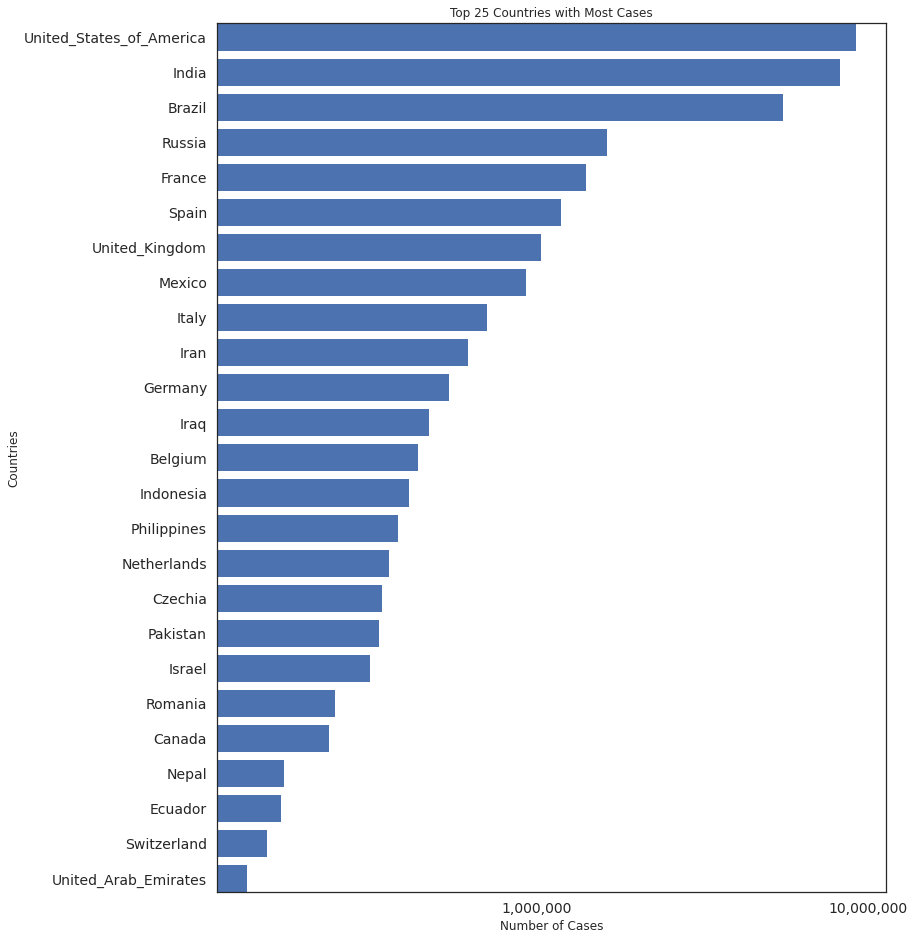

In [11]:
# Plotting graph
sns.set_theme(style='white')
plt.figure(figsize=(12,16))

#plt.bar(df_top_countries.index, df_top_countries['Total Cases'].values)
top_countries_list = format_names(df_top_countries.index)
plt.barh(df_top_countries.index[::-1], df_top_countries['Total Cases'].values[::-1]) # Reversing the order to have heighest values at the top of bar chart

#plt.axvline(Number_of_countries-0.5, 0,1, ls='--', c='black')
#plt.axhline(y=(Number_of_countries-0.5), ls='--', c='black')

plt.title(f'Top {len(top_countries)} Countries with Most Cases')

plt.xscale('log')
ax = plt.axes() # for updating 
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

#plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)  # To get labels in plain text 
#plt.xticks(rotation=90)
plt.margins(y=0)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Number of Cases')
plt.ylabel('Countries')
plt.show()

In [12]:
"""
# Plotting graph
sns.set_theme(style='white')
plt.figure(figsize=(12,16), dpi=90)

#plt.bar(df_top_countries.index, df_top_countries['Total Cases'].values)
top_countries_list = format_names(df_top_countries.index)
plt.barh(top_countries_list, df_top_countries['Total Cases'].values)

#plt.axvline(Number_of_countries-0.5, 0,1, ls='--', c='black')
plt.axhline(y=(Number_of_countries-0.5), ls='--', c='black')

plt.title(f'Top {len(top_countries)} Countries with Most Cases')

plt.xscale('log')
ax = plt.axes() # for updating 
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

#plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)  # To get labels in plain text 
#plt.xticks(rotation=90)
plt.margins(y=0)
plt.xlabel('Number of Cases')
plt.ylabel('Countries')
plt.show()
"""

"\n# Plotting graph\nsns.set_theme(style='white')\nplt.figure(figsize=(12,16), dpi=90)\n\n#plt.bar(df_top_countries.index, df_top_countries['Total Cases'].values)\ntop_countries_list = format_names(df_top_countries.index)\nplt.barh(top_countries_list, df_top_countries['Total Cases'].values)\n\n#plt.axvline(Number_of_countries-0.5, 0,1, ls='--', c='black')\nplt.axhline(y=(Number_of_countries-0.5), ls='--', c='black')\n\nplt.title(f'Top {len(top_countries)} Countries with Most Cases')\n\nplt.xscale('log')\nax = plt.axes() # for updating \nax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))\n\n#plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)  # To get labels in plain text \n#plt.xticks(rotation=90)\nplt.margins(y=0)\nplt.xlabel('Number of Cases')\nplt.ylabel('Countries')\nplt.show()\n"

## Average cases of top selected countries

In [13]:
dict_countries_avg = Counter(total_countries)

for country in dict_countries.keys():
  dict_countries_avg[country] = df_grouped.get_group(country)['cases'].mean()

# Average cases for all countries
df_avg_cases_countries = pd.DataFrame.from_dict(dict_countries_avg, orient='index', columns=['Average'])

# List of top selected countries
top_countries = list(df_top_countries.index)

# Average of selected top countries
avg_df = df_avg_cases_countries[df_avg_cases_countries.index.isin(top_countries)]
avg_df

,Average
Belgium,1431.568
Brazil,18005.536
Canada,768.964
Czechia,1109.234
Ecuador,558.396
France,4590.633
Germany,1769.568
India,26805.580
Indonesia,1371.375
Iran,2014.581


# Common Methods for All Experiments

## Testing Script


In [14]:
"""
def reshape_dataframe(*data: np.ndarray):
    # This function adds an extra dimension which is necessary in the LSTM
    arr = []
    for d in data:
        arr.append(np.reshape(np.array(d), (d.shape[0], 1, d.shape[1])))
    return arr


def train_test_lstm(regressor, X_train_lstm, y_train, X_val_lstm, y_val, X_test_lstm, patience, epochs):
    regressor.compile(loss='mae', optimizer='adagrad', metrics=['mse', 'mae'])

    history = regressor.fit(
        X_train_lstm,
        y_train,
        validation_data=(X_val_lstm, y_val),
        epochs=epochs,
        batch_size=10,
        callbacks=[EarlyStopping(monitor='val_loss',
                                 mode='min',
                                 patience=patience)])

    return regressor.predict(X_test_lstm)


def get_validation_set(df_train, batch_size=10):
    lst_idx = -1
    total_batches = len(df_train) // batch_size
    train_set, val_set = [], []

    for cur_batch in range(total_batches):
        start = lst_idx + 1
        end = start + batch_size
        if cur_batch % 2 == 0:
            train_set.append(df_train.iloc[start:end])
        else:
            val_set.append(df_train.iloc[start:end])

        lst_idx = end - 1  # adjusting last index because we add 1 in starting

    return pd.concat(train_set, ignore_index=True), pd.concat(val_set, ignore_index=True)


def define_lstm_model(x_train_lstm, layers, activations, patience):
    # Start defining the model
    input_shape = x_train_lstm.shape

    # Definining model first with LSTM n layers
    model = Sequential()
    model.add(LSTM(layers[0], input_shape=input_shape[1:], activation=activations[0], return_sequences=True))

    # Adding middle layers
    for l in range(1, len(layers)-1):
      model.add(LSTM(layers[l], activation=activations[l], return_sequences=True))
      model.add(Dropout(0.2))

    # Add last Dense and LSTMs layers
    if len(layers) > 1:
      model.add(Dense(layers[-1], activation=activations[-1]))
      model.add(Dropout(0.2))
      model.add(LSTM(layers[-1], activation=activations[-1]))

    model.add(Dense(1))  # output layer. Since we have only 1 output value
    # End defining model

    return model


def mean_absolute_percentage_error(actual, predicted):
    '''
    Mean absolute percentage error (MAPE).
    :return error
    '''
    actual =  np.array(actual)
    predicted = np.array(predicted)

    mask = actual != 0
    return (np.fabs(actual - predicted) / np.fabs(actual))[mask].mean()


def get_scores(y_true, model_predictions, days):
    mdl_evaluation_scores = {}
    mdl_evaluation_scores['EvaluationMeasurement'] = ['RMSE', 'MAE', 'MAPE']
    mdl_evaluation_scores['PretrainDays'] = [days] * len(mdl_evaluation_scores['EvaluationMeasurement'])

    for model in model_predictions:
        y_pred = model_predictions[model]
        if model == 'LSTM':
            rmse = mean_squared_error(y_true[:, np.newaxis], y_pred, squared=False)
            mae = mean_absolute_error(y_true[:, np.newaxis], y_pred)
            mape = mean_absolute_percentage_error(y_true[:, np.newaxis], y_pred)
        else:
            rmse = mean_squared_error(y_true, y_pred, squared=False)
            mae = mean_absolute_error(y_true, y_pred)
            mape = mean_absolute_percentage_error(y_true, y_pred)

        mdl_evaluation_scores[model] = [rmse, mae, mape]
    return pd.DataFrame(mdl_evaluation_scores)


def normalize_dataset(*dataframes):
    arr = []
    for df in dataframes:
        arr.append(StandardScaler().fit_transform(df))
    return arr


df = pd.read_csv(r'/content/csv_files/processed/United_States_of_America.csv')
model_predictions = {
        'LSTM': []
        #'MLPRegressor': [],
        #'LinearRegression': []
    }

layers_list = [[50, 30, 20, 10]]
epoch_list = [100]

for epochs in epoch_list:
    for layers in layers_list:
        #layers = [51, 30, 10]  # the final net will have n_layers +  2 + 1 = n*LSTMs + Dense + LSTM + output
        #epochs = 500
        activations = ['tanh', 'tanh', 'relu']
        patience = 20
        train = df.iloc[:150, :]
        test = df.iloc[150:180, :]  # Testing on set one month ahead only, hence day+30.

        X_train, y_train = train.iloc[:, 4:-1], train.iloc[:, -1]
        X_test, y_test = test.iloc[:, 4:-1], test.iloc[:, -1]

        # Seperating validation set from test set
        train_df, val_df = get_validation_set(train, batch_size=10)

        # Splitting test and validation into dependent and independent sets
        X_train_batch, y_train_batch = train_df.iloc[:, 4:-1], train_df.iloc[:, -1]  # Consist only odd batches
        X_val_batch, y_val_batch = val_df.iloc[:, 4:-1], val_df.iloc[:, -1]

        # Normalizing dataset
        X_train_lstm_norm, X_test_lstm_norm, X_val_lstm_norm = normalize_dataset(X_train_batch, X_test, X_val_batch)

        # Reshaping the dataframes
        X_train_lstm, X_val_lstm, X_test_lstm = reshape_dataframe(X_train_lstm_norm, X_val_lstm_norm, X_test_lstm_norm)

        # Defining models
        lstm_model = define_lstm_model(X_train_lstm, layers, activations, patience)
        model_predictions['LSTM'] = train_test_lstm(lstm_model, X_train_lstm, y_train_batch, X_val_lstm, y_val_batch, X_test_lstm, patience, epochs)
        print(model_predictions['LSTM'])

        mdl_evaluation_df = get_scores(y_test, model_predictions, 60)
        print("***********************************************************")
        print(f"Epochs = {epochs}, Layers = {layers}")
        print("=========================")
        print(mdl_evaluation_df)
        print("***********************************************************")
"""

'\ndef reshape_dataframe(*data: np.ndarray):\n    # This function adds an extra dimension which is necessary in the LSTM\n    arr = []\n    for d in data:\n        arr.append(np.reshape(np.array(d), (d.shape[0], 1, d.shape[1])))\n    return arr\n\n\ndef train_test_lstm(regressor, X_train_lstm, y_train, X_val_lstm, y_val, X_test_lstm, patience, epochs):\n    regressor.compile(loss=\'mae\', optimizer=\'adagrad\', metrics=[\'mse\', \'mae\'])\n\n    history = regressor.fit(\n        X_train_lstm,\n        y_train,\n        validation_data=(X_val_lstm, y_val),\n        epochs=epochs,\n        batch_size=10,\n        callbacks=[EarlyStopping(monitor=\'val_loss\',\n                                 mode=\'min\',\n                                 patience=patience)])\n\n    return regressor.predict(X_test_lstm)\n\n\ndef get_validation_set(df_train, batch_size=10):\n    lst_idx = -1\n    total_batches = len(df_train) // batch_size\n    train_set, val_set = [], []\n\n    for cur_batch in range(to

## Common Methods

#### Updated Number of countries

In [15]:
Number_of_countries = 2

In [16]:
# Global variables for countries
countries = top_countries[0:Number_of_countries]

In [17]:
# Return a combined dataframe for a each error statistics(MAE,RMSE,MAPE etc) along with the newly added mean row.
def get_metric_with_mean(result: pd.DataFrame, error_metric: str)->pd.DataFrame:
  df_grouped = result.groupby('EvaluationMeasurement')
  df = df_grouped.get_group(error_metric).reset_index(drop=True)
  df = df.append(df.describe().loc['mean'])
  return df

In [18]:
def calc_mean_to_max_error(df, max_of_pretrain_days, max_of_df):
  i=-1
  for row_num in range(len(df)-1):  # Go before mean row
    i += 1
    for col_num in df.columns[2:]:
      df.loc[row_num,col_num] = df.loc[row_num,col_num]/max_of_pretrain_days[i] 
  
  for col in df.columns[2:]:
      df.loc['mean',col] = df.loc['mean',col]/max_of_df

  return df

In [19]:
# Note: Do not change the filenames, since they are later being used for visualizations 
def save_runtime(df,path,country=None,static_learner=True,alternate_batch=False, transpose=False):
  df = df.apply(pd.to_numeric,errors='ignore') # Converting the dataframe to numeric
  df = df.round(decimal) # Setting the precision
  
  # if transpose flag is set to true
  if transpose:
    df = df.transpose()

  if country==None:
    if static_learner:
      df.to_latex(f'{path}/combined25country_runtime_static.tex')
      df.to_csv(f'{path}/combined25country_runtime_static.csv')
    else:
      if alternate_batch:
         df.to_latex(f'{path}/combined25country_runtime_incremental_alternate_batch.tex')
         df.to_csv(f'{path}/combined25country_runtime_incremental_alternate_batch.csv')
      else:
        df.to_latex(f'{path}/combined25country_runtime_incremental.tex')
        df.to_csv(f'{path}/combined25country_runtime_incremental.csv')
  else:
    if static_learner:
      df.to_latex(f'{path}/{country}_runtime_static.tex')
      df.to_csv(f'{path}/{country}_runtime_static.csv')
    else:
      df.to_latex(f'{path}/{country}_runtime_incremental.tex')
      df.to_csv(f'{path}/{country}_runtime_incremental.csv')

In [20]:
# Note: Do not change the filenames, since they are later being used for visualizations 
def save_summary_table(df,path,country=False,static_learner=True,alternate_batch=False, transpose=False):

  df = df.apply(pd.to_numeric,errors='ignore') # Converting the dataframe to numeric
  df = df.round(decimal) # Setting the precision
  
  # if transpose flag is set to true
  if transpose:
    df = df.transpose()

  if country:
    metric = df.loc['EvaluationMeasurement'].unique()[0]
    if static_learner:
      df.to_latex(f'{path}/top_countries_{metric}_summary_table_static.tex')
      df.to_csv(f'{path}/top_countries_{metric}_summary_table_static.csv')
    else:
      df.to_latex(f'{path}/top_countries_{metric}_summary_table_incremental.tex')
      df.to_csv(f'{path}/top_countries_{metric}_summary_table_incremental.csv')
    
  else:
    if static_learner:
      df.to_latex(f'{path}/combined25country_summary_table_static.tex')
      df.to_csv(f'{path}/combined25country_summary_table_static.csv')
    else:
      if alternate_batch:
         df.to_latex(f'{path}/combined25country_summary_table_incremental_alternate_batch.tex')
         df.to_csv(f'{path}/combined25country_summary_table_incremental_alternate_batch.csv')
      else:
        df.to_latex(f'{path}/combined25country_summary_table_incremental.tex')
        df.to_csv(f'{path}/combined25country_summary_table_incremental.csv')
    

In [21]:
# Note: Do not change the filenames since they are later being used for visualizations
def save_metrics(df, path, country=None, static_learner=True, alternate_batch=False, transpose=False): 
  df = df.apply(pd.to_numeric,errors='ignore') # Converting the dataframe to numeric
  df = df.round(decimal) # Setting the precision
  
  # if transpose flag is set to true
  if transpose:
    df = df.transpose()

  metric_type = df.loc['EvaluationMeasurement'].unique()[0]
  if country==None:
    if static_learner:
      df.to_latex(f'{path}/combined25country_{metric_type}_static.tex')
      df.to_csv(f'{path}/combined25country_{metric_type}_static.csv')
    else:
      if alternate_batch:
         df.to_latex(f'{path}/combined25country_{metric_type}_incremental_alternate_batch.tex')
         df.to_csv(f'{path}/combined25country_{metric_type}_incremental_alternate_batch.csv')
      else:
        df.to_latex(f'{path}/combined25country_{metric_type}_incremental.tex')
        df.to_csv(f'{path}/combined25country_{metric_type}_incremental.csv')
  else:
    if static_learner:
      df.to_latex(f'{path}/{country}_{metric_type}_static.tex')
      df.to_csv(f'{path}/{country}_{metric_type}_static.csv')
    else:
      df.to_latex(f'{path}/{country}_{metric_type}_incremental.tex')
      df.to_csv(f'{path}/{country}_{metric_type}_incremental.csv')

In [22]:
def save_combined_summary_table(df, path, static_learner=False,transpose=False):
  df = df.apply(pd.to_numeric,errors='ignore')
  df = df.round(decimal)
  if transpose:
    df = df.transpose()
  
  if static_learner:
    save_path = f'{path}/summary_table_combined_mean_static'
  else:
    save_path = f'{path}/summary_table_combined_mean_incremental'

  df.to_csv(f'{save_path}.csv')
  df.to_latex(f'{save_path}.tex')

In [23]:
def display_runtime_per_country(results_runtime,countries):
  for i in range(len(countries)):
    print(f'_____________Running Time for {countries[i]}________________')
    print(results_runtime[i].to_string())
    print('\n')

In [24]:
def calc_save_err_metric_countrywise(countries, error_metrics, results, max_of_pretrain_per_country, max_cases_per_country, path, static_learner, transpose):
  countrywise_error_scores={}
  for i in range(len(countries)):
    country_error_score = []
    for error_metric in error_metrics:
      
      df_error_metric = get_metric_with_mean(results[i], error_metric=error_metric)

      #if error_metric != 'MAPE':
      #  df_error_metric = calc_mean_to_max_error(df_error_metric, max_of_pretrain_per_country[i], max_cases_per_country[i])

      country_error_score.append(df_error_metric)
      display_countrywise_scores(countries[i],df_error_metric)

      # Transposing the metrics while saving
      save_metrics(df_error_metric, path=path, country=countries[i], static_learner=static_learner, transpose=transpose)
      
    countrywise_error_scores[countries[i]] = pd.concat(country_error_score,ignore_index=True)
    
  return countrywise_error_scores

In [25]:
def calc_save_err_metric_combined(error_metrics, results, max_of_pretrain_days, max_selected_countries, path, static_learner, alternate_batch, transpose):
  combined_err_metric = []
  for error_metric in error_metrics:
    df_error_metric = get_metric_with_mean(results, error_metric=error_metric)

    #if error_metric != 'MAPE':
    #  df_error_metric = calc_mean_to_max_error(df_error_metric, max_of_pretrain_days, max_selected_countries)

    # Transposing the metrics while saving
    save_metrics(df_error_metric, path=path, static_learner=static_learner, alternate_batch=alternate_batch, transpose=transpose)
    
    combined_err_metric.append(df_error_metric)
  return (pd.concat(combined_err_metric, ignore_index=True))

In [26]:
def get_summary_table(df_result, df_runtime_result, error_metrics, static_learner=True):
  sum_metric=[]
  measure_col_name = 'Metric'
  
  # Setting start row and column for static and incremental learner
  for metric in error_metrics:
    start_row = 'mean'
    if static_learner:
      start_col='RandomForest'
    else:
      start_col='HT_Reg'

    df_metric = get_metric_with_mean(df_result, metric)
    df_row = pd.DataFrame([df_metric.loc[start_row][start_col:]])
    
    df_row[measure_col_name] = str(metric)    
    sum_metric.append(df_row)

  # Adding run time
  df_runtime_row = pd.DataFrame([df_runtime_result.describe().loc[start_row][start_col:]])
  df_runtime_row[measure_col_name]='Time(sec)'
  sum_metric.append(df_runtime_row)

  df_summary = pd.concat(sum_metric, ignore_index=True)
  df_summary.set_index(measure_col_name, inplace=True)

  return df_summary

In [27]:
def get_summary_table_countrywise(df_result_dict, error_metrics, static_learner=True):  #df_runtime_result,
  summary_metric=[]
  measure_col_name = f'Country({str(error_metrics[0])})'
  eval_measure_col = 'EvaluationMeasurement'
  start_row = 'mean'
  if static_learner:
    start_col='RandomForest'
  else:
    start_col='HT_Reg'

  for country in df_result_dict.keys():
    df_result = df_result_dict[country]

    # Setting start row and column for static and incremental learner
    for metric in error_metrics:      
      df_metric = get_metric_with_mean(df_result, metric)
      df_row = pd.DataFrame([df_metric.loc[start_row][start_col:]])
      df_row[eval_measure_col] = metric
      df_row[measure_col_name] = country
      summary_metric.append(df_row)

  df_summary = pd.concat(summary_metric, ignore_index=True)
  df_summary.set_index(measure_col_name, inplace=True)

  return df_summary

In [28]:
def get_sum_table_combined_mean(countrywise_error_score_incremental,results_runtime, static_learner=False):
  sum_table_combined_mean=[]
  measure_col_name = 'Metric'
  start_row = 'mean'
  if static_learner:
    start_col = 'RandomForest'
  else:
    start_col= 'HT_Reg'

  for metric in error_metrics:
    df_sum_cur_metric = get_summary_table_countrywise(countrywise_error_score_incremental, [metric], static_learner=static_learner)
    df_row = pd.DataFrame([df_sum_cur_metric.describe().loc[start_row]])

    df_row[measure_col_name] = metric
    sum_table_combined_mean.append(df_row)

  # Adding run time
  df_runtime = pd.concat(results_runtime, ignore_index=True).describe().loc[start_row][start_col:]
  df_runtime_row = pd.DataFrame([df_runtime])
  df_runtime_row[measure_col_name]='Time(sec)'
  sum_table_combined_mean.append(df_runtime_row)

  # Concating results to one dataframe
  sum_table_combined_mean = pd.concat(sum_table_combined_mean, ignore_index=True)
  sum_table_combined_mean.set_index(measure_col_name, inplace=True)
  return sum_table_combined_mean

In [29]:
def check_significance(target_pop, competitor_pop, significance_at: float):
    """
    Comparing algorithms per batch or per country pairs (exp 2 or 1 respectively), 
      so for each pair, we compare the significance of the best algo to all of the the other algos.
    Ttest performed if the distribution is normal, otherwise we perform a non-parametric test.
    """
    model_pop, population = target_pop, competitor_pop  
    
    # Normality tests
    if len(model_pop) >= 8:  # skew test not valid for smaller populations
      value_mdl, p_mdl = normaltest(model_pop.values)
      value_pop, p_pop = normaltest(population.values)
      if (p_mdl >= 0.05) & (p_pop >= 0.05):
  #       print('It is likely that both populations are normal. Thus, running T-Test...')
          tset, pval = stats.ttest_ind(model_pop, population)
          if pval < significance_at:    # alpha value is 0.05 or 5%
              significant = 'Significant (Ttest)'
          else:
              significant = 'Not Significant (Ttest)'
      else:
  #         print('It is unlikely that the result is normal. Thus, running Wilcoxon test...')
          if np.sum(np.subtract(list(model_pop), list(competitor_pop))) != 0.0:  # if values are identical the test will crash, but we now it's not significant
              tset, pval = stats.wilcoxon(model_pop, population)
              if pval < significance_at:    # alpha value is 0.05 or 5%
                  significant = 'Significant (Wilcox Test)'
              else:
                  significant = 'Not Significant (Wilcox Test)'
          else:
  #             print('Warning: results are identical')
              tset, pval = stats.ttest_ind(model_pop, population)
              significant = 'Not Significant (Wilcox Test)'
    else:
      print('Population too small.')
      if np.sum(np.subtract(list(model_pop), list(competitor_pop))) != 0.0:  # if values are identical the test will crash, but we now it's not significant
          tset, pval = stats.wilcoxon(model_pop, population)
          if pval < significance_at:    # alpha value is 0.05 or 5%
              significant = 'Significant (Wilcox Test)'
          else:
              significant = 'Not Significant (Wilcox Test)'
    return pval, significant 

## Combining Dataset

In [30]:
def sortby_date_and_set_index(df):
  df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
  df.sort_values('date', inplace=True)
  df.set_index('date', inplace=True)
  return df

In [31]:
def get_dataset_with_target(countries, df_grouped):
  
  # Empty list to store Dataframes of each country
  frames = []
  
  for country in countries:
    
    df = df_grouped.get_group(country)

    # Creating feature 'day_no'
    df['day_no']= pd.Series([i for i in range(1,len(df)+1)], index=df.index)

    # Reordering features
    df = df[['day_no', 'country','cases']]

    # Adding features through lags
    df = create_features_with_lags(df)

    # Creating target with last 10 days cases
    df['target'] = df.iloc[:,[2]+[i*-1 for i in range(1,10)]].mean(axis=1)

    # Dropping null columns
    df.dropna(how='any', axis=0, inplace=True)

    # Dropping mid columns
    drop_columns = list(df.loc[:,'cases_t-38':'cases_t-1'].columns)
    df.drop(drop_columns, axis=1, inplace=True)

    frames.append(df)

  return (pd.concat(frames, ignore_index=True))

In [32]:
def reshape_dataframe(*data: np.ndarray):
    # This function adds an extra dimension which is necessary in the LSTM
    arr = []
    for d in data:
        arr.append(np.reshape(np.array(d), (d.shape[0], 1, d.shape[1])))
    return arr

In [33]:
def get_countries_sortedby_cases(valid_countries, df_grouped):
  # A dictionary of all countries
  dict_countries = Counter(valid_countries)

  for country in dict_countries.keys():
    dict_countries[country] = df_grouped.get_group(country)['cases'].sum()

  # Sorting countries based on number of cases
  countries_sortedby_cases = sorted(dict_countries.items(), key=lambda dict_countries: dict_countries[1], reverse=True)

  # Creating dataframe 
  df_countries_sortedbycases = pd.DataFrame.from_dict(dict(countries_sortedby_cases), orient='index', columns=['Total Cases'])
  
  return df_countries_sortedbycases

In [34]:
# Getting a list of valid countries
def get_countries_with_valid_size(df):
  total_countries = list(df_grouped.groups.keys())

  # A list for countries with required datasize
  valid_countries = []

  # List of countries with more than 230 records. Because, max training size = 150, lags removed = 50, prediction = 30.
  for country in total_countries:
    if len(df_grouped.get_group(country)) >= 230:
      valid_countries.append(country)

  return valid_countries

In [35]:
def preprocess_dataset(df):  
  # Selecting required features
  df= df[['dateRep','cases','countriesAndTerritories']]

  # Rename features
  df.rename(columns={'countriesAndTerritories':'country', 'dateRep':'date'}, inplace=True)

  # Convert to date, sort and set index
  df = sortby_date_and_set_index(df)

  return df

In [36]:
# Calculating maximum of dataframe for every pretrain size
def calc_max_of_pretrain_days(pretrain_days,df)->list:
  max_of_pretrain_days = []
  
  for day in pretrain_days:
    df_subset = create_subset(df,day)
    max_of_pretrain_days.append(df_subset['cases'].max())
  
  return max_of_pretrain_days

In [37]:
def display_scores(results):
  #print(f'_________________________________{country}____________________________________________')
  df_MAE = get_metric_with_mean(results,'MAE' )
  df_RMSE = get_metric_with_mean(results,'RMSE')
  df_MAPE = get_metric_with_mean(results,'MAPE')
  print('MAE Score')
  print(df_MAE.to_string())
  print('-----------------------------------------------------------------------------------')
  print('RMSE Score')
  print(df_RMSE.to_string())
  print('-----------------------------------------------------------------------------------')
  print('MAPE Score')
  print(df_MAPE.to_string())
  print('\n\n')

## Alternate Batch

In [38]:
def get_alternate_batch_records_idx(batch_size,total_records): 
  total_batches = total_records//batch_size
  current_batch=1
  start_idx = 0
  end_idx = batch_size
  idx_list = []
  
  while current_batch <= total_batches:
    if current_batch%2!=0:
      idx_list.extend([x for x in range(start_idx,end_idx)])
      start_idx = idx_list[-1]+(batch_size+1)
      end_idx = start_idx + batch_size
    current_batch += 1

  return idx_list

In [39]:
def create_alternate_batch_subset(df,days,batch_size):
  df_grouped = df.groupby('country')
  countries = df['country'].unique()
  frame1,frame2 = [],[]

  for country in countries:
    df_cur_country = df_grouped.get_group(country)

    df1 = df_cur_country.iloc[0:days//2]
    df2 = df_cur_country.iloc[days:days+30]  # Adding 30 for a testing batch that is one month ahead
    
    # Selecting alternate batches
    idx = get_alternate_batch_records_idx(batch_size,total_records=len(df2))
    df2 = df2.iloc[idx]

    # Appending dataframes
    frame1.append(df1)
    frame2.append(df2)

  r1 = pd.concat(frame1, ignore_index=True)
  r2 = pd.concat(frame2, ignore_index=True)
  r = r1.append(r2, ignore_index=True)
  
  return (r)

## Incremental Learner

In [40]:
def instantiate_regressors():
  ht_reg = HoeffdingTreeRegressor()
  hat_reg = HoeffdingAdaptiveTreeRegressor()
  arf_reg = AdaptiveRandomForestRegressor()
  pa_reg = PassiveAggressiveRegressor(max_iter=1, random_state=0, tol=1e-3)

  model = [ht_reg, hat_reg, arf_reg, pa_reg]
  model_names = ['HT_Reg', 'HAT_Reg', 'ARF_Reg', 'PA_Reg']

  return model, model_names

In [41]:
def get_error_scores_per_model(evaluator, mdl_evaluation_scores)-> pd.DataFrame:
  
  for i in range(len(evaluator.model_names)):
    # Desired error metrics
    mse = evaluator.mean_eval_measurements[i].get_mean_square_error()
    mae = evaluator.mean_eval_measurements[i].get_average_error()
    mape = evaluator.mean_eval_measurements[i].get_mean_absolute_percentage_error()
    rmse = sqrt(mse)

    # Dictionary of errors per model
    mdl_evaluation_scores[str(evaluator.model_names[i])] = [rmse, mae, mape]

  return(pd.DataFrame(mdl_evaluation_scores))


In [42]:
def get_running_time_per_model_incremental_learner(evaluator,day):
    cols = ['PretrainDays']  # Adding pretrain as first column
    cols += evaluator.model_names  # Adding remaining columns of different algorithm
    running_time = []
    running_time.append(day)
    for i in range(len(evaluator.model_names)):
        running_time.append(evaluator.running_time_measurements[i]._total_time)

    return (pd.DataFrame([running_time],columns=cols))  # Passing running_time as a list of list to insert it as a row

In [43]:
def display_countrywise_scores(country,df_error_metric):
  print(f'_________________________________{country}____________________________________________')
  print(df_error_metric.to_string())
  print('\n\n')

In [44]:
# Create a dataframe of all countries with pre-train size = pretrain days and test&train size = pretrain days
def create_subset(result,days):
  result_grouped = result.groupby('country')
  countries = result['country'].unique()
  frame1,frame2 = [],[]
  for country in countries:
    df = result_grouped.get_group(country) 
    df1 = df.iloc[0:days]
    df2 = df.iloc[days:days+30]
    frame1.append(df1)
    frame2.append(df2)

  r1 = pd.concat(frame1, ignore_index=True)
  r2 = pd.concat(frame2, ignore_index=True)
  r = r1.append(r2, ignore_index=True)
  
  return (r)

## Static Learner

In [45]:
def mean_absolute_percentage_error(actual, predicted):
    """
    Mean absolute percentage error (MAPE).
    :return error
    """
    actual =  np.array(actual) 
    predicted = np.array(predicted) 

    mask = actual != 0
    return (np.fabs(actual - predicted) / np.fabs(actual))[mask].mean()

In [46]:
def get_scores(y_true, model_predictions, days):
    mdl_evaluation_scores = {}
    mdl_evaluation_scores['EvaluationMeasurement'] = ['RMSE', 'MAE', 'MAPE']
    mdl_evaluation_scores['PretrainDays'] = [days] * len(mdl_evaluation_scores['EvaluationMeasurement'])

    for model in model_predictions:
        y_pred = model_predictions[model]
        if model == 'LSTM':
            rmse = mean_squared_error(y_true[:, np.newaxis], y_pred, squared=False)
            mae = mean_absolute_error(y_true[:, np.newaxis], y_pred)
            mape = mean_absolute_percentage_error(y_true[:, np.newaxis], y_pred)
        else:
            rmse = mean_squared_error(y_true, y_pred, squared=False)
            mae = mean_absolute_error(y_true, y_pred)
            mape = mean_absolute_percentage_error(y_true, y_pred)

        mdl_evaluation_scores[model] = [rmse, mae, mape]
    return pd.DataFrame(mdl_evaluation_scores)

In [47]:
def get_running_time_per_model_static_learner(model_predictions,total_execution_time):
    cols = ['PretrainDays']
    cols += model_predictions.keys()
    return pd.DataFrame(total_execution_time, columns=cols)


def measure(wrapped_func):
    @wraps(wrapped_func)
    def _time_it(*args, **kwargs):
        start = pc_timer()
        try:
            model_predictions = wrapped_func(*args, **kwargs)
        finally:
            end_ = pc_timer() - start
            return model_predictions, end_
    return _time_it


@measure
def train_test_model(regressor, X_train, y_train, X_test):
    regressor.fit(X_train, y_train)
    return regressor.predict(X_test)


@measure
def train_test_lstm(regressor, X_train_lstm, y_train, X_val_lstm, y_val, X_test_lstm, patience, epochs, batch_size_lstm):
    regressor.compile(loss='mae', optimizer='adagrad', metrics=['mse', 'mae'])

    history = regressor.fit(
        X_train_lstm,
        y_train,
        validation_data=(X_val_lstm, y_val),
        epochs=epochs,
        batch_size=batch_size_lstm,
        callbacks=[EarlyStopping(monitor='val_loss',
                                 mode='min',
                                 patience=patience)])

    return regressor.predict(X_test_lstm)

In [48]:
def define_lstm_model(x_train_lstm, layers, activations, patience):
    # Start defining the model
    input_shape = x_train_lstm.shape

    # Definining model first with LSTM n layers
    model = Sequential()
    model.add(LSTM(layers[0], input_shape=input_shape[1:], activation=activations[0], return_sequences=True))

    # Adding middle layers
    for l in range(1, len(layers)-1):
      model.add(LSTM(layers[l], activation=activations[l], return_sequences=True))
      model.add(Dropout(0.2))

    # Add last Dense and LSTMs layers
    if len(layers) > 1:
      model.add(Dense(layers[-1], activation=activations[-1]))
      model.add(Dropout(0.2))
      model.add(LSTM(layers[-1], activation=activations[-1]))

    model.add(Dense(1))  # output layer. Since we have only 1 output value
    # End defining model

    return model


In [49]:
def normalize_dataset(*dataframes):
    arr = []
    for df in dataframes:
        arr.append(StandardScaler().fit_transform(df))
    return arr

In [50]:
def get_validation_set(df_train, batch_size=10):
    lst_idx = -1
    total_batches = len(df_train) // batch_size
    train_set, val_set = [], []

    for cur_batch in range(total_batches):
        start = lst_idx + 1
        end = start + batch_size
        if cur_batch % 2 == 0:
            train_set.append(df_train.iloc[start:end])
        else:
            val_set.append(df_train.iloc[start:end])

        lst_idx = end - 1  # adjusting last index because we add 1 in starting

    return pd.concat(train_set, ignore_index=True), pd.concat(val_set, ignore_index=True)


# Experiment 1
Training and testing with five countries individually. 

### Dataset Description

* cases(t): Number of cases on current day(Column='cases') 

* cases(t-n): Number of cases 'n' days before current day 't'

* 30 day gap: Training from day number t-89 to t-39(50 days). Then a gap of 30 days and then creating target by averaging t to t-9(10 Days).


In [51]:
# Sample set for understanding dataset
sample_df = pd.read_csv(f'{csv_processed_path}/United_States_of_America.csv')
sample_df.tail(5)

,date,day_no,country,cases,cases_t-89,cases_t-88,cases_t-87,cases_t-86,cases_t-85,cases_t-84,cases_t-83,cases_t-82,cases_t-81,cases_t-80,cases_t-79,cases_t-78,cases_t-77,cases_t-76,cases_t-75,cases_t-74,cases_t-73,cases_t-72,cases_t-71,cases_t-70,cases_t-69,cases_t-68,cases_t-67,cases_t-66,cases_t-65,cases_t-64,cases_t-63,cases_t-62,cases_t-61,cases_t-60,cases_t-59,cases_t-58,cases_t-57,cases_t-56,cases_t-55,cases_t-54,cases_t-53,cases_t-52,cases_t-51,cases_t-50,cases_t-49,cases_t-48,cases_t-47,cases_t-46,cases_t-45,cases_t-44,cases_t-43,cases_t-42,cases_t-41,cases_t-40,target
214,2020-10-29,304,United_States_of_America,78371,67023.000,58407.000,47511.000,45607.000,57525.000,52804.000,59755.000,58150.000,56221.000,46847.000,49530.000,46813.000,55941.000,51094.000,64838.000,48085.000,42104.000,35056.000,44091.000,47426.000,44005.000,49880.000,44378.000,34506.000,38298.000,38119.000,42848.000,45909.000,49654.000,44143.000,35581.000,33850.000,44639.000,38754.000,36249.000,51071.000,44140.000,30555.000,24250.000,27122.000,31927.000,37507.000,48061.000,40820.000,33871.000,34841.000,51473.000,24598.000,43567.000,50209.000,70342.900
215,2020-10-30,305,United_States_of_America,88130,58407.000,47511.000,45607.000,57525.000,52804.000,59755.000,58150.000,56221.000,46847.000,49530.000,46813.000,55941.000,51094.000,64838.000,48085.000,42104.000,35056.000,44091.000,47426.000,44005.000,49880.000,44378.000,34506.000,38298.000,38119.000,42848.000,45909.000,49654.000,44143.000,35581.000,33850.000,44639.000,38754.000,36249.000,51071.000,44140.000,30555.000,24250.000,27122.000,31927.000,37507.000,48061.000,40820.000,33871.000,34841.000,51473.000,24598.000,43567.000,50209.000,40295.000,73139.900
216,2020-10-31,306,United_States_of_America,101273,47511.000,45607.000,57525.000,52804.000,59755.000,58150.000,56221.000,46847.000,49530.000,46813.000,55941.000,51094.000,64838.000,48085.000,42104.000,35056.000,44091.000,47426.000,44005.000,49880.000,44378.000,34506.000,38298.000,38119.000,42848.000,45909.000,49654.000,44143.000,35581.000,33850.000,44639.000,38754.000,36249.000,51071.000,44140.000,30555.000,24250.000,27122.000,31927.000,37507.000,48061.000,40820.000,33871.000,34841.000,51473.000,24598.000,43567.000,50209.000,40295.000,39852.000,77412.300
217,2020-11-01,307,United_States_of_America,78934,45607.000,57525.000,52804.000,59755.000,58150.000,56221.000,46847.000,49530.000,46813.000,55941.000,51094.000,64838.000,48085.000,42104.000,35056.000,44091.000,47426.000,44005.000,49880.000,44378.000,34506.000,38298.000,38119.000,42848.000,45909.000,49654.000,44143.000,35581.000,33850.000,44639.000,38754.000,36249.000,51071.000,44140.000,30555.000,24250.000,27122.000,31927.000,37507.000,48061.000,40820.000,33871.000,34841.000,51473.000,24598.000,43567.000,50209.000,40295.000,39852.000,53153.000,79007.900
218,2020-11-02,308,United_States_of_America,81001,57525.000,52804.000,59755.000,58150.000,56221.000,46847.000,49530.000,46813.000,55941.000,51094.000,64838.000,48085.000,42104.000,35056.000,44091.000,47426.000,44005.000,49880.000,44378.000,34506.000,38298.000,38119.000,42848.000,45909.000,49654.000,44143.000,35581.000,33850.000,44639.000,38754.000,36249.000,51071.000,44140.000,30555.000,24250.000,27122.000,31927.000,37507.000,48061.000,40820.000,33871.000,34841.000,51473.000,24598.000,43567.000,50209.000,40295.000,39852.000,53153.000,38307.000,79902.200


## Incremental Learner

In [52]:
def scikit_multiflow(df, pretrain_days):

  # Creating a stream from dataframe
  stream = DataStream(np.array(df.iloc[:,4:-1]), y=np.array(df.iloc[:,-1])) # Selecting features x=[t-89:t-39] and y=[target]. TODO: Drop columns with name 

  model, model_names = instantiate_regressors()

  frames, running_time_frames = [], []

  # Setup the evaluator
  for day in pretrain_days:

      pretrain_days = day
      max_samples = pretrain_days + 30  #Testing on set one month ahead only

      evaluator = EvaluatePrequential(show_plot=False,
                                    pretrain_size=day,
                                    metrics = ['mean_square_error', 'mean_absolute_error', 'mean_absolute_percentage_error'], 
                                    max_samples=max_samples)
      # Run evaluation
      evaluator.evaluate(stream=stream, model=model, model_names=model_names)

      # Dictionary to store each iteration error scores
      mdl_evaluation_scores = {}

      # Adding Evaluation Measurements and pretraining days
      mdl_evaluation_scores['EvaluationMeasurement'] = ['RMSE','MAE','MAPE']
      mdl_evaluation_scores['PretrainDays'] = [day] * len(mdl_evaluation_scores['EvaluationMeasurement'])
      mdl_evaluation_df = get_error_scores_per_model(evaluator, mdl_evaluation_scores)

      # Errors of each model on a specific pre-train days
      frames.append(mdl_evaluation_df)

      # Run time for each algorithm
      running_time_frames.append(get_running_time_per_model_incremental_learner(evaluator, day))

  # Final Run Time DataFrame
  running_time_df = pd.concat(running_time_frames,ignore_index=True)

  # Final Evaluation Score Dataframe
  evaluation_scores_df = pd.concat(frames, ignore_index=True)
  return evaluation_scores_df, running_time_df

In [53]:
# Training all countries
results_incremental = []
results_runtime_incremental = []
max_of_pretrain_per_country = []
max_cases_per_country = []

for country in countries:
  # Read each country  
  df_country = pd.read_csv(f'{csv_processed_path}/{country}.csv')

  # Get evaluation scores and running time for country
  evaluation_scores_df, running_time_df = scikit_multiflow(df_country,pretrain_days)

  # Appending evaluation scores and runtime for each country
  results_incremental.append(evaluation_scores_df)
  results_runtime_incremental.append(running_time_df)

  # Get max of each pretrain subset and for each country dataset
  max_of_pretrain_per_country.append(calc_max_of_pretrain_days(pretrain_days,df_country))
  max_cases_per_country.append(df_country['cases'].max())

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 30 sample(s).
Evaluating...
 #################### [98%] [1.25s]
Processed samples: 60
Mean performance:
HT_Reg - MSE          : 10238155.8984
HT_Reg - MAPE          : 0.1077
HT_Reg - MAE          : 2726.229562
HAT_Reg - MSE          : 5523865.6454
HAT_Reg - MAPE          : 0.0818
HAT_Reg - MAE          : 2039.594063
ARF_Reg - MSE          : 392726616.5186
ARF_Reg - MAPE          : 0.7492
ARF_Reg - MAE          : 18533.652319
PA_Reg - MSE          : 62927183059.5860
PA_Reg - MAPE          : 8.2249
PA_Reg - MAE          : 193965.777290
Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 60 sample(s).
Evaluating...
 #################### [99%] [2.09s]
Processed samples: 90
Mean performance:
HT_Reg - MSE          : 458139484.8674
HT_Reg - MAPE          : 0.7729
HT_Reg - MAE          : 16774.342114
HAT_Reg - MSE          : 445932376.2100
HAT_Reg - MAPE          : 0.7507
HAT_Reg - MAE          : 16309.741901
ARF_Reg - M

In [54]:
# Save the running time for each country
for i in range(len(countries)):
  save_runtime(results_runtime_incremental[i], path=exp1_runtime_path, country = countries[i], static_learner=False)

# Display countrywise running time complexity
display_runtime_per_country(results_runtime_incremental, countries)

_____________Running Time for United_States_of_America________________
   PretrainDays  HT_Reg  HAT_Reg  ARF_Reg  PA_Reg
0            30   0.044    0.061    1.075   0.054
1            60   0.068    0.088    1.898   0.035
2            90   0.147    0.175    2.736   0.037
3           120   0.206    0.235    4.348   0.032
4           150   0.284    0.317    4.572   0.029
5           180   0.340    0.381    5.715   0.031


_____________Running Time for India________________
   PretrainDays  HT_Reg  HAT_Reg  ARF_Reg  PA_Reg
0            30   0.035    0.045    1.062   0.033
1            60   0.059    0.077    1.608   0.031
2            90   0.117    0.146    2.737   0.037
3           120   0.183    0.217    4.365   0.032
4           150   0.247    0.290    6.053   0.035
5           180   0.306    0.359    6.637   0.031




In [55]:
countrywise_error_score_incremental = calc_save_err_metric_countrywise(countries, error_metrics, results_incremental, max_of_pretrain_per_country, max_cases_per_country, path=exp1_path, static_learner=False, transpose=True)

_________________________________United_States_of_America____________________________________________
     EvaluationMeasurement  PretrainDays    HT_Reg   HAT_Reg   ARF_Reg      PA_Reg
0                      MAE        30.000  2726.230  2039.594 18533.652  193965.777
1                      MAE        60.000 16774.342 16309.742 20714.415  670387.456
2                      MAE        90.000 14299.673 14298.643 14976.154  472027.577
3                      MAE       120.000 10347.791 10347.791  7274.473  799895.356
4                      MAE       150.000  1875.442  1875.442 26903.884 1717538.680
5                      MAE       180.000  1833.208  1833.208 14185.387  760302.267
mean                   NaN       105.000  7976.114  7784.070 17097.994  769019.519



_________________________________United_States_of_America____________________________________________
     EvaluationMeasurement  PretrainDays  HT_Reg  HAT_Reg  ARF_Reg  PA_Reg
0                     MAPE        30.000   0.108    0.

In [56]:
# Get summary table for each country for specified metric
summary_table_countrywise_incremental = get_summary_table_countrywise(countrywise_error_score_incremental, ['MAPE'], static_learner=False)

# Saving the summary table
save_summary_table(summary_table_countrywise_incremental, exp1_summary_path,country=True, static_learner=False,alternate_batch=False,transpose=True)

summary_table_countrywise_incremental

,HT_Reg,HAT_Reg,ARF_Reg,PA_Reg,EvaluationMeasurement
Country(MAPE),,,,,
United_States_of_America,0.231,0.223,0.510,20.214,MAPE
India,0.255,0.273,0.938,1.266,MAPE


In [57]:
sum_inc_countrywise_mean = get_sum_table_combined_mean(countrywise_error_score_incremental,results_runtime_incremental)
save_combined_summary_table(sum_inc_countrywise_mean, exp1_summary_path, static_learner=False, transpose=True) 
sum_inc_countrywise_mean

,HT_Reg,HAT_Reg,ARF_Reg,PA_Reg
Metric,,,,
MAE,11615.731,12065.563,31007.984,419412.046
MAPE,0.243,0.248,0.724,10.740
RMSE,17967.024,18401.863,38610.153,605822.555
Time(sec),0.170,0.199,3.567,0.035


## Static Learner

In [58]:
def scikit_learn(df, training_days):
    frames = []
    model_predictions = {
        'RandomForest': [],
        'GradientBoosting': [],
        'LinearSVR': [],
        'DecisionTree': [],
        'BayesianRidge': [],
        'LSTM': []
        #'MLPRegressor': [],
        #'LinearRegression': []
    }
    total_execution_time = []
            
    # LSTM (TODO: feel free to put the whole LSTM definition in a funtion)
    # params (others like epoch and batch size are also hardcoded in train_test_lstm())
    layers = [50, 30, 20, 10]  # the final net will have n_layers +  2 + 1 = n*LSTMs + Dense + LSTM + output
    activations = ['tanh', 'tanh', 'relu']
    epochs = 500
    patience = 20
    batch_size_lstm = 10

    for day in training_days:
        
        cur_exec_time = [day]  # Keeping runing time for each pre-train set

        train = df.iloc[:day, :]
        test = df.iloc[day:day + 30, :]  # Testing on set one month ahead only, hence day+30.
        
        # training and test sets for all models except LSTM
        X_train, y_train = train.iloc[:, 4:-1], train.iloc[:, -1]
        X_test, y_test = test.iloc[:, 4:-1], test.iloc[:, -1]

        # Seperating validation set from test set
        train_df, val_df = get_validation_set(train, batch_size=10)

        # Splitting test and validation into dependent and independent sets
        X_train_batch, y_train_batch = train_df.iloc[:, 4:-1], train_df.iloc[:, -1]  # Consist only odd batches
        X_val_batch, y_val_batch = val_df.iloc[:, 4:-1], val_df.iloc[:, -1]

        # Normalizing dataset
        X_train_lstm_norm, X_test_lstm_norm, X_val_lstm_norm = normalize_dataset(X_train_batch, X_test, X_val_batch)

        # Reshaping the dataframes
        X_train_lstm, X_val_lstm, X_test_lstm = reshape_dataframe(X_train_lstm_norm, X_val_lstm_norm, X_test_lstm_norm)
       

        rf_reg = RandomForestRegressor(max_depth=2, random_state=0)
        model_predictions['RandomForest'], exec_time = train_test_model(rf_reg, X_train,y_train,X_test)
        cur_exec_time.append(exec_time)


        gb_reg = GradientBoostingRegressor(random_state=0)
        model_predictions['GradientBoosting'], exec_time = train_test_model(gb_reg, X_train, y_train, X_test)
        cur_exec_time.append(exec_time)


        lsv_reg = LinearSVR(random_state=0, tol=1e-5)
        model_predictions['LinearSVR'], exec_time = train_test_model(lsv_reg, X_train, y_train, X_test)
        cur_exec_time.append(exec_time)


        dt_reg = DecisionTreeRegressor(random_state=0)
        model_predictions['DecisionTree'], exec_time = train_test_model(dt_reg, X_train, y_train, X_test)
        cur_exec_time.append(exec_time)


        br_reg = BayesianRidge()
        model_predictions['BayesianRidge'], exec_time = train_test_model(br_reg, X_train, y_train, X_test)
        cur_exec_time.append(exec_time)

        
        lstm_model = define_lstm_model(X_train_lstm, layers, activations, patience)
        model_predictions['LSTM'],exec_time = train_test_lstm(lstm_model, X_train_lstm, y_train_batch, X_val_lstm, y_val_batch, X_test_lstm, patience, epochs, batch_size_lstm)
        cur_exec_time.append(exec_time)

        
        mdl_evaluation_df = get_scores(y_test, model_predictions, day)
        total_execution_time.append(cur_exec_time)
        frames.append(mdl_evaluation_df)

    evaluation_score_df = pd.concat(frames, ignore_index=True)
    running_time_df = get_running_time_per_model_static_learner(model_predictions,total_execution_time)
    return evaluation_score_df, running_time_df


In [59]:
# Training all countries
results_static = []
results_runtime_static = []
max_of_pretrain_per_country = []
max_cases_per_country = []

for country in countries:
  # Read country wise csv file
  df_country = pd.read_csv(f'{csv_processed_path}/{country}.csv')

  # Evaluation scores and running time of each algorithm over different pre-training days
  evaluation_scores_df, running_time_df = scikit_learn(df_country, pretrain_days)

  # Append result of each pretrain size in results
  results_static.append(evaluation_scores_df)

  # Appending every country runtime 
  results_runtime_static.append(running_time_df)

  # Calculating max cases per country based on pre-train size
  max_of_pretrain_per_country.append(calc_max_of_pretrain_days(pretrain_days,df_country))

  # Maximum case of each country
  max_cases_per_country.append(df_country['cases'].max())

Train on 20 samples, validate on 10 samples
Epoch 1/500
20/20 [==============================] - 2s 86ms/step - loss: 24206.4590 - mse: 624614592.0000 - mae: 24206.4590 - val_loss: 30089.3652 - val_mse: 906656384.0000 - val_mae: 30089.3652
Epoch 2/500
20/20 [==============================] - 0s 976us/step - loss: 24206.4375 - mse: 624613504.0000 - mae: 24206.4375 - val_loss: 30089.3496 - val_mse: 906655360.0000 - val_mae: 30089.3496
Epoch 3/500
20/20 [==============================] - 0s 886us/step - loss: 24206.4209 - mse: 624612736.0000 - mae: 24206.4219 - val_loss: 30089.3340 - val_mse: 906654528.0000 - val_mae: 30089.3340
Epoch 4/500
20/20 [==============================] - 0s 766us/step - loss: 24206.4072 - mse: 624612032.0000 - mae: 24206.4082 - val_loss: 30089.3223 - val_mse: 906653696.0000 - val_mae: 30089.3223
Epoch 5/500
20/20 [==============================] - 0s 885us/step - loss: 24206.3916 - mse: 624611328.0000 - mae: 24206.3906 - val_loss: 30089.3066 - val_mse: 906652800

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, incr

Train on 30 samples, validate on 30 samples
Epoch 1/500
30/30 [==============================] - 2s 61ms/step - loss: 24466.5072 - mse: 625249472.0000 - mae: 24466.5078 - val_loss: 26857.1940 - val_mse: 732522368.0000 - val_mae: 26857.1934
Epoch 2/500
30/30 [==============================] - 0s 785us/step - loss: 24466.4505 - mse: 625246784.0000 - mae: 24466.4492 - val_loss: 26857.1029 - val_mse: 732517312.0000 - val_mae: 26857.1035
Epoch 3/500
30/30 [==============================] - 0s 790us/step - loss: 24466.3346 - mse: 625240768.0000 - mae: 24466.3340 - val_loss: 26856.6966 - val_mse: 732493952.0000 - val_mae: 26856.6953
Epoch 4/500
30/30 [==============================] - 0s 722us/step - loss: 24465.4375 - mse: 625197184.0000 - mae: 24465.4375 - val_loss: 26854.9310 - val_mse: 732391488.0000 - val_mae: 26854.9336
Epoch 5/500
30/30 [==============================] - 0s 776us/step - loss: 24463.5658 - mse: 625109824.0000 - mae: 24463.5664 - val_loss: 26852.1849 - val_mse: 732232128

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, incr

Train on 50 samples, validate on 40 samples
Epoch 1/500
50/50 [==============================] - 2s 36ms/step - loss: 24047.3449 - mse: 597862336.0000 - mae: 24047.3457 - val_loss: 25553.9263 - val_mse: 666561536.0000 - val_mae: 25553.9258
Epoch 2/500
50/50 [==============================] - 0s 653us/step - loss: 24047.2871 - mse: 597859456.0000 - mae: 24047.2871 - val_loss: 25553.8306 - val_mse: 666556288.0000 - val_mae: 25553.8320
Epoch 3/500
50/50 [==============================] - 0s 716us/step - loss: 24047.0934 - mse: 597849792.0000 - mae: 24047.0918 - val_loss: 25553.4033 - val_mse: 666532160.0000 - val_mae: 25553.4023
Epoch 4/500
50/50 [==============================] - 0s 716us/step - loss: 24046.0656 - mse: 597799488.0000 - mae: 24046.0645 - val_loss: 25551.9575 - val_mse: 666450944.0000 - val_mae: 25551.9570
Epoch 5/500
50/50 [==============================] - 0s 680us/step - loss: 24044.8473 - mse: 597743552.0000 - mae: 24044.8477 - val_loss: 25549.9736 - val_mse: 666340992

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, incr

Train on 60 samples, validate on 60 samples
Epoch 1/500
60/60 [==============================] - 2s 31ms/step - loss: 29102.6322 - mse: 994167616.0000 - mae: 29102.6328 - val_loss: 34679.7454 - val_mse: 1438888192.0000 - val_mae: 34679.7461
Epoch 2/500
60/60 [==============================] - 0s 712us/step - loss: 29102.3854 - mse: 994153920.0000 - mae: 29102.3848 - val_loss: 34678.9860 - val_mse: 1438840064.0000 - val_mae: 34678.9844
Epoch 3/500
60/60 [==============================] - 0s 645us/step - loss: 29099.8747 - mse: 994013568.0000 - mae: 29099.8750 - val_loss: 34673.4147 - val_mse: 1438478976.0000 - val_mae: 34673.4141
Epoch 4/500
60/60 [==============================] - 0s 713us/step - loss: 29092.4642 - mse: 993632576.0000 - mae: 29092.4629 - val_loss: 34662.8197 - val_mse: 1437768576.0000 - val_mae: 34662.8203
Epoch 5/500
60/60 [==============================] - 0s 651us/step - loss: 29081.5013 - mse: 992990016.0000 - mae: 29081.5020 - val_loss: 34649.5166 - val_mse: 14368

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, incr

Train on 80 samples, validate on 70 samples
Epoch 1/500
80/80 [==============================] - 2s 25ms/step - loss: 35870.6692 - mse: 1551455872.0000 - mae: 35870.6680 - val_loss: 37657.9049 - val_mse: 1674816512.0000 - val_mae: 37657.9062
Epoch 2/500
80/80 [==============================] - 0s 611us/step - loss: 35868.2598 - mse: 1551233408.0000 - mae: 35868.2578 - val_loss: 37651.3184 - val_mse: 1674217984.0000 - val_mae: 37651.3164
Epoch 3/500
80/80 [==============================] - 0s 634us/step - loss: 35859.4966 - mse: 1550482560.0000 - mae: 35859.4922 - val_loss: 37639.0670 - val_mse: 1673136512.0000 - val_mae: 37639.0664
Epoch 4/500
80/80 [==============================] - 0s 572us/step - loss: 35842.4529 - mse: 1549064832.0000 - mae: 35842.4570 - val_loss: 37619.6663 - val_mse: 1671475072.0000 - val_mae: 37619.6680
Epoch 5/500
80/80 [==============================] - 0s 574us/step - loss: 35819.6001 - mse: 1547043328.0000 - mae: 35819.6016 - val_loss: 37594.4660 - val_mse: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, incr

Train on 90 samples, validate on 90 samples
Epoch 1/500
90/90 [==============================] - 2s 21ms/step - loss: 36156.3741 - mse: 1543867776.0000 - mae: 36156.3750 - val_loss: 38268.4221 - val_mse: 1666703872.0000 - val_mae: 38268.4180
Epoch 2/500
90/90 [==============================] - 0s 630us/step - loss: 36155.6851 - mse: 1543818112.0000 - mae: 36155.6875 - val_loss: 38266.5326 - val_mse: 1666569344.0000 - val_mae: 38266.5352
Epoch 3/500
90/90 [==============================] - 0s 572us/step - loss: 36149.4516 - mse: 1543345280.0000 - mae: 36149.4492 - val_loss: 38254.3349 - val_mse: 1665638912.0000 - val_mae: 38254.3320
Epoch 4/500
90/90 [==============================] - 0s 562us/step - loss: 36129.5028 - mse: 1541902080.0000 - mae: 36129.5039 - val_loss: 38231.0653 - val_mse: 1663857792.0000 - val_mae: 38231.0625
Epoch 5/500
90/90 [==============================] - 0s 736us/step - loss: 36103.1649 - mse: 1539859840.0000 - mae: 36103.1641 - val_loss: 38200.9970 - val_mse: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # This is added back by InteractiveShellApp.init_path()


Train on 20 samples, validate on 10 samples
Epoch 1/500
20/20 [==============================] - 2s 100ms/step - loss: 738.9736 - mse: 829285.1250 - mae: 738.9736 - val_loss: 711.0170 - val_mse: 527265.8750 - val_mae: 711.0170
Epoch 2/500
20/20 [==============================] - 0s 988us/step - loss: 738.9530 - mse: 829252.1875 - mae: 738.9530 - val_loss: 710.9996 - val_mse: 527241.3125 - val_mae: 710.9996
Epoch 3/500
20/20 [==============================] - 0s 858us/step - loss: 738.9351 - mse: 829228.1875 - mae: 738.9351 - val_loss: 710.9828 - val_mse: 527217.3750 - val_mae: 710.9828
Epoch 4/500
20/20 [==============================] - 0s 917us/step - loss: 738.9178 - mse: 829201.0000 - mae: 738.9178 - val_loss: 710.9669 - val_mse: 527194.6875 - val_mae: 710.9669
Epoch 5/500
20/20 [==============================] - 0s 1ms/step - loss: 738.9032 - mse: 829182.3750 - mae: 738.9032 - val_loss: 710.9512 - val_mse: 527172.3750 - val_mae: 710.9512
Epoch 6/500
20/20 [========================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, incr

Train on 30 samples, validate on 30 samples
Epoch 1/500
30/30 [==============================] - 2s 58ms/step - loss: 1637.3267 - mse: 4521314.5000 - mae: 1637.3267 - val_loss: 2644.3728 - val_mse: 10815954.0000 - val_mae: 2644.3726
Epoch 2/500
30/30 [==============================] - 0s 778us/step - loss: 1637.2820 - mse: 4521166.0000 - mae: 1637.2820 - val_loss: 2644.3269 - val_mse: 10815739.0000 - val_mae: 2644.3269
Epoch 3/500
30/30 [==============================] - 0s 827us/step - loss: 1637.2223 - mse: 4521024.0000 - mae: 1637.2224 - val_loss: 2644.1948 - val_mse: 10815286.0000 - val_mae: 2644.1948
Epoch 4/500
30/30 [==============================] - 0s 910us/step - loss: 1636.9770 - mse: 4520646.5000 - mae: 1636.9769 - val_loss: 2643.2267 - val_mse: 10812595.0000 - val_mae: 2643.2266
Epoch 5/500
30/30 [==============================] - 0s 857us/step - loss: 1635.1793 - mse: 4517695.0000 - mae: 1635.1793 - val_loss: 2639.4412 - val_mse: 10802165.0000 - val_mae: 2639.4412
Epoch 6

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, incr

Train on 50 samples, validate on 40 samples
Epoch 1/500
50/50 [==============================] - 2s 43ms/step - loss: 5100.8959 - mse: 48605656.0000 - mae: 5100.8960 - val_loss: 4477.7876 - val_mse: 33086694.0000 - val_mae: 4477.7876
Epoch 2/500
50/50 [==============================] - 0s 809us/step - loss: 5100.2202 - mse: 48602352.0000 - mae: 5100.2207 - val_loss: 4475.0573 - val_mse: 33073946.0000 - val_mae: 4475.0576
Epoch 3/500
50/50 [==============================] - 0s 669us/step - loss: 5093.8772 - mse: 48566240.0000 - mae: 5093.8770 - val_loss: 4463.2372 - val_mse: 33012042.0000 - val_mae: 4463.2373
Epoch 4/500
50/50 [==============================] - 0s 652us/step - loss: 5081.5674 - mse: 48509280.0000 - mae: 5081.5674 - val_loss: 4448.2789 - val_mse: 32927280.0000 - val_mae: 4448.2788
Epoch 5/500
50/50 [==============================] - 0s 645us/step - loss: 5063.5371 - mse: 48386468.0000 - mae: 5063.5371 - val_loss: 4429.7110 - val_mse: 32812794.0000 - val_mae: 4429.7109
Ep

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, incr

Train on 60 samples, validate on 60 samples
Epoch 1/500
60/60 [==============================] - 2s 29ms/step - loss: 8366.7961 - mse: 142962704.0000 - mae: 8366.7959 - val_loss: 12068.7987 - val_mse: 298674304.0000 - val_mae: 12068.7979
Epoch 2/500
60/60 [==============================] - 0s 671us/step - loss: 8366.5840 - mse: 142960784.0000 - mae: 8366.5840 - val_loss: 12068.1345 - val_mse: 298667680.0000 - val_mae: 12068.1357
Epoch 3/500
60/60 [==============================] - 0s 599us/step - loss: 8364.8382 - mse: 142949600.0000 - mae: 8364.8379 - val_loss: 12064.1945 - val_mse: 298630560.0000 - val_mae: 12064.1943
Epoch 4/500
60/60 [==============================] - 0s 649us/step - loss: 8359.4850 - mse: 142911504.0000 - mae: 8359.4854 - val_loss: 12054.8656 - val_mse: 298539936.0000 - val_mae: 12054.8643
Epoch 5/500
60/60 [==============================] - 0s 613us/step - loss: 8351.2972 - mse: 142855136.0000 - mae: 8351.2979 - val_loss: 12044.8492 - val_mse: 298431616.0000 - va

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, incr

Train on 80 samples, validate on 70 samples
Epoch 1/500
80/80 [==============================] - 2s 27ms/step - loss: 20378.7129 - mse: 916129408.0000 - mae: 20378.7129 - val_loss: 18686.1482 - val_mse: 743990720.0000 - val_mae: 18686.1465
Epoch 2/500
80/80 [==============================] - 0s 599us/step - loss: 20374.7318 - mse: 916041728.0000 - mae: 20374.7324 - val_loss: 18674.6115 - val_mse: 743715136.0000 - val_mae: 18674.6113
Epoch 3/500
80/80 [==============================] - 0s 542us/step - loss: 20355.7858 - mse: 915429568.0000 - mae: 20355.7852 - val_loss: 18643.1271 - val_mse: 742691968.0000 - val_mae: 18643.1270
Epoch 4/500
80/80 [==============================] - 0s 535us/step - loss: 20320.3308 - mse: 914239168.0000 - mae: 20320.3301 - val_loss: 18595.5639 - val_mse: 741037056.0000 - val_mae: 18595.5645
Epoch 5/500
80/80 [==============================] - 0s 516us/step - loss: 20270.1161 - mse: 912216896.0000 - mae: 20270.1172 - val_loss: 18538.7237 - val_mse: 738959488

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, incr

Train on 90 samples, validate on 90 samples
Epoch 1/500
90/90 [==============================] - 2s 21ms/step - loss: 27657.2554 - mse: 1635663104.0000 - mae: 27657.2559 - val_loss: 32679.8760 - val_mse: 2082572800.0000 - val_mae: 32679.8770
Epoch 2/500
90/90 [==============================] - 0s 734us/step - loss: 27654.7624 - mse: 1635605760.0000 - mae: 27654.7637 - val_loss: 32671.7702 - val_mse: 2082310400.0000 - val_mae: 32671.7715
Epoch 3/500
90/90 [==============================] - 0s 643us/step - loss: 27638.8979 - mse: 1634974464.0000 - mae: 27638.8965 - val_loss: 32646.3189 - val_mse: 2080991872.0000 - val_mae: 32646.3203
Epoch 4/500
90/90 [==============================] - 0s 632us/step - loss: 27611.8299 - mse: 1633804416.0000 - mae: 27611.8301 - val_loss: 32611.6390 - val_mse: 2078943488.0000 - val_mae: 32611.6387
Epoch 5/500
90/90 [==============================] - 0s 699us/step - loss: 27567.7331 - mse: 1631396992.0000 - mae: 27567.7324 - val_loss: 32565.9644 - val_mse: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # This is added back by InteractiveShellApp.init_path()


In [60]:
# Save the running time for each country
for i in range(len(countries)):
  save_runtime(results_runtime_static[i], path=exp1_runtime_path, country = countries[i], static_learner=True)

display_runtime_per_country(results_runtime_static, countries)

_____________Running Time for United_States_of_America________________
   PretrainDays  RandomForest  GradientBoosting  LinearSVR  DecisionTree  BayesianRidge   LSTM
0            30         0.133             0.037      0.002         0.002          0.028 18.409
1            60         0.124             0.061      0.014         0.003          0.004 14.257
2            90         0.136             0.099      0.013         0.004          0.004 26.862
3           120         0.166             0.130      0.018         0.005          0.004 17.998
4           150         0.172             0.165      0.023         0.006          0.004 21.070
5           180         0.182             0.196      0.028         0.006          0.005 20.264


_____________Running Time for India________________
   PretrainDays  RandomForest  GradientBoosting  LinearSVR  DecisionTree  BayesianRidge   LSTM
0            30         0.127             0.034      0.002         0.002          0.003  8.524
1            60     

In [61]:
countrywise_error_scores_static = calc_save_err_metric_countrywise(countries, error_metrics, results_static, max_of_pretrain_per_country, max_cases_per_country, path=exp1_path, static_learner=True, transpose=True)

_________________________________United_States_of_America____________________________________________
     EvaluationMeasurement  PretrainDays  RandomForest  GradientBoosting   LinearSVR  DecisionTree  BayesianRidge      LSTM
0                      MAE        30.000      4093.543          3867.215 1006480.785      4560.880      99068.637  2468.920
1                      MAE        60.000      2042.897          1590.215 2886240.906      1845.367       1676.672  9810.243
2                      MAE        90.000     28342.025         25233.845  153275.689     25486.720      26921.287 32518.019
3                      MAE       120.000      8530.576          6842.980   71920.223      6927.423      10656.728 38917.236
4                      MAE       150.000      5149.964          5649.100   54311.707      8471.413       4885.341 10335.895
5                      MAE       180.000      7393.098          7508.353   62839.832      7452.797      31479.673 20919.696
mean                   NaN    

In [62]:
summary_table_countrywise_static = get_summary_table_countrywise(countrywise_error_scores_static, ['MAPE'], static_learner=True)

# Saving the transposed matrix
save_summary_table(summary_table_countrywise_static, exp1_summary_path, country=True, static_learner=True, alternate_batch=False, transpose=True)

summary_table_countrywise_static

,RandomForest,GradientBoosting,LinearSVR,DecisionTree,BayesianRidge,LSTM,EvaluationMeasurement
Country(MAPE),,,,,,,
United_States_of_America,0.200,0.182,28.520,0.200,0.949,0.400,MAPE
India,0.385,0.322,3.108,0.324,1.652,0.714,MAPE


In [63]:
sum_static_countrywise_mean = get_sum_table_combined_mean(countrywise_error_scores_static,results_runtime_static,static_learner=True)
save_combined_summary_table(sum_static_countrywise_mean, exp1_summary_path, static_learner=True, transpose=True) 
sum_static_countrywise_mean

,RandomForest,GradientBoosting,LinearSVR,DecisionTree,BayesianRidge,LSTM
Metric,,,,,,
MAE,11233.086,9681.005,383544.317,10035.923,34353.449,23444.829
MAPE,0.293,0.252,15.814,0.262,1.300,0.557
RMSE,12538.820,11159.715,471928.167,11495.010,40010.787,26450.155
Time(sec),0.148,0.106,0.015,0.004,0.006,18.380


## Significance tests for Experiment 1

In [64]:
## EXP1
# Significance results for Experiment 1
err_metric_for_significance = 'MAPE'
significance_thresh = 0.01
plot_pop = False

# Concatenating a population of all results (as in boxplot) for experiment 1
concated_df = pd.concat([summary_table_countrywise_incremental.transpose(), summary_table_countrywise_static.transpose()]).transpose().drop(columns=['EvaluationMeasurement'], axis=1)
concated_df


,HT_Reg,HAT_Reg,ARF_Reg,PA_Reg,RandomForest,GradientBoosting,LinearSVR,DecisionTree,BayesianRidge,LSTM
Country(MAPE),,,,,,,,,,
United_States_of_America,0.231,0.223,0.510,20.214,0.200,0.182,28.520,0.200,0.949,0.400
India,0.255,0.273,0.938,1.266,0.385,0.322,3.108,0.324,1.652,0.714


In [65]:
# Selecting the best algorithm for statistical comparisons
# We want to know if the best is statistically significantly better compared to the rest.
best_algo = concated_df.mean().sort_values(ascending=True).index[0]
best_algo

'HT_Reg'

In [66]:
print('AVG results across countries')
concated_df.mean()

AVG results across countries


HT_Reg              0.243
HAT_Reg             0.248
ARF_Reg             0.724
PA_Reg             10.740
RandomForest        0.293
GradientBoosting    0.252
LinearSVR          15.814
DecisionTree        0.262
BayesianRidge       1.300
LSTM                0.557
dtype: float64

In [67]:
print('STDEV across countries')
concated_df.std()

STDEV across countries


HT_Reg              0.017
HAT_Reg             0.035
ARF_Reg             0.302
PA_Reg             13.398
RandomForest        0.131
GradientBoosting    0.099
LinearSVR          17.969
DecisionTree        0.088
BayesianRidge       0.497
LSTM                0.222
dtype: float64

In [68]:
# Iterate through all the other algorithms to see if the difference in results is significant
competitors = list(concated_df.columns)
competitors.remove(best_algo)
#TODO: 
for significance_thresh in [0.01,0.05]:
  print(f'Running significane at: {significance_thresh}')
  for competitor in competitors:
    # print(competitor)
    pval, significant = check_significance_nonparam(concated_df[best_algo], concated_df[competitor], significance_at=significance_thresh, plot_flag = plot_pop)
    print(f'Comparison of {best_algo} to {competitor} pvalue: {pval}   /  significant?: {significant}')

Running significane at: 0.01


NameError: ignored

# Experiment 2

### Creating Combined dataset

In [ ]:
# Reading file 
#url = 'https://drive.google.com/file/d/1e7NsptfEFLG2gGLykYlrzjNbDJLiRbGm/view?usp=sharing'
url = 'https://drive.google.com/file/d/1VH-nkePskK3gT6U5qkoOP-0hFT4beszC/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)
num_selected_countries = 2

In [ ]:

# Pre-processing dataset
df = preprocess_dataset(df)

# Grouping records by country
df_grouped = df.groupby('country')

# Taking only those countries which have sufficient data records
#valid_countries = get_countries_with_valid_size(df_grouped)

# Sorting countries by number of cases
df_countries_sortedbycases = get_countries_sortedby_cases(valid_countries, df_grouped)

# Taking only top selected countries
top_selected_countries = df_countries_sortedbycases.iloc[0:num_selected_countries].index

# Calculating targets and lags for the above countries
result = get_dataset_with_target(top_selected_countries,df_grouped)

# Calculating targets and lags for the above countries
result = get_dataset_with_target(top_selected_countries,df_grouped)

# Getting max of each subset in pretrain size
max_of_pretrain_days = calc_max_of_pretrain_days(pretrain_days,result)

# Mean of top selected countries
max_selected_countries = result['cases'].max()  

### Incremental Learner

In [ ]:
def scikit_multiflow(df, pretrain_days):

  model, model_names = instantiate_regressors()

  len_countries = len(df['country'].unique())

  frames , running_time_frames = [], []

  # Setup the evaluator
  for day in pretrain_days:

      df_subset = create_subset(df,day)
      
      # Creating a stream from dataframe
      stream = DataStream(np.array(df_subset.iloc[:,4:-1]), y=np.array(df_subset.iloc[:,-1])) #TODO: Drop columns with name 

      pretrain_size = day * len_countries
      max_samples = (day + 30) * len_countries #Testing on set one month ahead only

      evaluator = EvaluatePrequential(show_plot=False,
                                    pretrain_size=pretrain_size,
                                    metrics = ['mean_square_error', 'mean_absolute_error', 'mean_absolute_percentage_error'],
                                    max_samples=max_samples)
      # Run evaluation
      evaluator.evaluate(stream=stream, model=model, model_names=model_names)

      # Dictionary to store each iteration error scores
      mdl_evaluation_scores = {}

      # Adding Evaluation Measurements and pretraining days
      mdl_evaluation_scores['EvaluationMeasurement'] = ['RMSE','MAE','MAPE'] #,'MSE']
      mdl_evaluation_scores['PretrainDays'] = [day] * len(mdl_evaluation_scores['EvaluationMeasurement'])

      mdl_evaluation_df = get_error_scores_per_model(evaluator, mdl_evaluation_scores)

      # Errors of each model on a specific pre-train days
      frames.append(mdl_evaluation_df)

      # Run time for each algorithm
      running_time_frames.append(get_running_time_per_model_incremental_learner(evaluator, day))

   # Final Run Time DataFrame
  running_time_df = pd.concat(running_time_frames,ignore_index=True)

  # Final Evaluation Score Dataframe
  evaluation_scores_df = pd.concat(frames, ignore_index=True)
  return evaluation_scores_df, running_time_df

In [ ]:
result_skmlflow, running_time_combined_incremental = scikit_multiflow(result, pretrain_days)

In [ ]:
df_skmlflow = calc_save_err_metric_combined(error_metrics, result_skmlflow, max_of_pretrain_days, max_selected_countries, path=exp2_path, static_learner=False, alternate_batch=False, transpose=True)

In [ ]:
save_runtime(running_time_combined_incremental, path=exp2_runtime_path, static_learner=False)
running_time_combined_incremental

In [ ]:
summary_table_incremental = get_summary_table(df_skmlflow, running_time_combined_incremental, error_metrics, static_learner=False)
save_summary_table(summary_table_incremental, exp2_summary_path,static_learner=False,alternate_batch=False, transpose=True)
summary_table_incremental

### Static Learner

In [ ]:
def scikit_learn(df, training_days):
  len_countries = len(df['country'].unique())
  frames = []
  model_predictions = {
      'RandomForest':[],
      'GradientBoosting':[],
      'LinearSVR':[],
      'DecisionTree':[],
      'BayesianRidge':[],
      'LSTM': []
      #'MLPRegressor': [],
      #'LinearRegression': []
    }

  # LSTM (TODO: feel free to put the whole LSTM definition in a funtion)
  # params (others like epoch and batch size are also hardcoded in train_test_lstm())
  layers = [20, 10, 10]  # the final net will have n_layers +  2 + 1 = n*LSTMs + Dense + LSTM + output
  activations = ['tanh', 'tanh', 'relu']
  patience = 20
  total_execution_time = []

  for day in training_days:

    df_subset = create_subset(df,day)
    
    train_end_day = day * len_countries
    test_end_day = (day+30) * len_countries

    train = df_subset.iloc[:train_end_day, :] 
    test = df_subset.iloc[train_end_day:test_end_day, :]  # Testing on set one month ahead only, hence day+30.
    test_df, val_df = get_validation_set(test, batch_size=10)  # Getting validation set from test set

    # training and test sets for all models except LSTM
    X_train, y_train = train.iloc[:,4:-1], train.iloc[:,-1]
    X_test, y_test = test.iloc[:,4:-1], test.iloc[:,-1]

    # Validation and test set for LSTM
    X_test_lstm, y_test_lstm = test_df.iloc[:, 4:-1], test_df.iloc[:, -1]
    X_val, y_val = val_df.iloc[:, 4:-1], val_df.iloc[:, -1]

    X_train_lstm, X_val, X_test_lstm = reshape_dataframe(X_train, X_val, X_test_lstm)  # reshaping the vector for lstm
    cur_exec_time = [day]

    rf_reg = RandomForestRegressor(max_depth=2, random_state=0)
    model_predictions['RandomForest'], exec_time = train_test_model(rf_reg, X_train,y_train,X_test)
    cur_exec_time.append(exec_time)


    gb_reg = GradientBoostingRegressor(random_state=0)
    model_predictions['GradientBoosting'], exec_time = train_test_model(gb_reg, X_train, y_train, X_test)
    cur_exec_time.append(exec_time)


    lsv_reg = LinearSVR(random_state=0, tol=1e-5)
    model_predictions['LinearSVR'], exec_time = train_test_model(lsv_reg, X_train, y_train, X_test)
    cur_exec_time.append(exec_time)


    dt_reg = DecisionTreeRegressor(random_state=0)
    model_predictions['DecisionTree'], exec_time = train_test_model(dt_reg, X_train, y_train, X_test)
    cur_exec_time.append(exec_time)


    br_reg = BayesianRidge()
    model_predictions['BayesianRidge'], exec_time = train_test_model(br_reg, X_train, y_train, X_test)
    cur_exec_time.append(exec_time)


    '''
    mlp_reg = MLPRegressor(random_state=1, max_iter=500)
    model_predictions['MLPRegressor'], exec_time = train_test_model(mlp_reg, X_train, y_train, X_test)
    cur_exec_time.append(exec_time)


    lin_reg = LinearRegression()
    model_predictions['LinearRegression'], exec_time = train_test_model(lin_reg, X_train, y_train, X_test)
    cur_exec_time.append(exec_time)
    '''

    lstm_model = define_lstm_model(X_train_lstm, layers, activations, patience)
    model_predictions['LSTM'], exec_time = train_test_lstm(lstm_model, X_train_lstm, y_train, X_val, y_val, X_test_lstm, patience)         
    cur_exec_time.append(exec_time)

    mdl_evaluation_df = get_scores(y_test,y_test_lstm, model_predictions, day)
    total_execution_time.append(cur_exec_time)
    frames.append(mdl_evaluation_df)

  evaluation_score_df = pd.concat(frames, ignore_index=True)
  running_time_df = get_running_time_per_model_static_learner(model_predictions,total_execution_time)
  return evaluation_score_df, running_time_df

In [ ]:
result_sklearn, running_time_static = scikit_learn(result, pretrain_days)

In [ ]:
df_sklearn = calc_save_err_metric_combined(error_metrics, result_sklearn, max_of_pretrain_days, max_selected_countries, path=exp2_path, static_learner=True, alternate_batch=False, transpose=True)
display_scores(df_sklearn)

In [ ]:
save_runtime(running_time_static, path=exp2_runtime_path, static_learner=True)
running_time_static

In [ ]:
summary_table_static = get_summary_table(df_sklearn, running_time_static, error_metrics, static_learner=True)
save_summary_table(summary_table_static, exp2_summary_path,static_learner=True,alternate_batch=False, transpose=True)
summary_table_static

## Incremental Learner: Alternate Batches



In [ ]:
def scikit_multiflow_alternate_batch(df, pretrain_days):

  model, model_names = instantiate_regressors()

  len_countries = len(df['country'].unique())

  frames , running_time_frames = [], []

  # Setup the evaluator
  for day in pretrain_days:

      df_subset = create_alternate_batch_subset(df,day,batch_size=10)

      # Creating a stream from dataframe
      stream = DataStream(np.array(df_subset.iloc[:,4:-1]), y=np.array(df_subset.iloc[:,-1])) #TODO: Drop columns with name 

      pretrain_size = (day//2) * len_countries
      max_samples = (day//2 + 20) * len_countries #Testing on set one month ahead only

      evaluator = EvaluatePrequential(show_plot=False,
                                    pretrain_size=pretrain_size,
                                    metrics = ['mean_square_error', 'mean_absolute_error', 'mean_absolute_percentage_error'],
                                    max_samples=max_samples)
      # Run evaluation
      evaluator.evaluate(stream=stream, model=model, model_names=model_names)

      # Dictionary to store each iteration error scores
      mdl_evaluation_scores = {}

      # Adding Evaluation Measurements and pretraining days
      mdl_evaluation_scores['EvaluationMeasurement'] = ['RMSE','MAE','MAPE'] #,'MSE']
      mdl_evaluation_scores['PretrainDays'] = [day//2] * len(mdl_evaluation_scores['EvaluationMeasurement'])

      mdl_evaluation_df = get_error_scores_per_model(evaluator, mdl_evaluation_scores)

      # Errors of each model on a specific pre-train days
      frames.append(mdl_evaluation_df)

      # Run time for each algorithm
      running_time_frames.append(get_running_time_per_model_incremental_learner(evaluator, day))

  # Final Run Time DataFrame
  running_time_df = pd.concat(running_time_frames,ignore_index=True)

  # Final Evaluation Score Dataframe
  evaluation_scores_df = pd.concat(frames, ignore_index=True)
  return evaluation_scores_df, running_time_df

In [ ]:
result_skmlflow_alternate_batch, running_time_incremental_alternate_batch = scikit_multiflow_alternate_batch(result, pretrain_days)

In [ ]:
df_alternate_batch = calc_save_err_metric_combined(error_metrics, result_skmlflow_alternate_batch, max_of_pretrain_days, max_selected_countries, path=exp2_path, static_learner=False, alternate_batch=True, transpose=True)

In [ ]:
display_scores(df_alternate_batch)

In [ ]:
save_runtime(running_time_incremental_alternate_batch, path=exp2_runtime_path, static_learner=False, alternate_batch=True)
running_time_incremental_alternate_batch

In [ ]:
summary_table_incremental_alternate = get_summary_table(df_alternate_batch, running_time_incremental_alternate_batch, error_metrics, static_learner=False)
save_summary_table(summary_table_incremental_alternate, exp2_summary_path,static_learner=False,alternate_batch=True, transpose=True)
summary_table_incremental_alternate

## Significance tests for Experiment 2

In [ ]:
## EXP2
# Significance results for Experiment 2
err_metric_for_significance = 'MAPE'
significance_thresh = 0.05
plot_pop = False

# Concatenating a population of all results (as in boxplot) for experiment 2
# This is done for runs per batch for experiment 2. But for experiment 1 it's done for runs per country (their final averages, like the result sent to the boxplots).
static = df_sklearn[df_sklearn['EvaluationMeasurement'] == err_metric_for_significance].drop(columns=['EvaluationMeasurement'], axis=1).transpose()
incremental = df_alternate_batch[df_alternate_batch['EvaluationMeasurement'] == err_metric_for_significance].drop(columns=['EvaluationMeasurement', 'PretrainDays'], axis=1).transpose()
concated_df = pd.concat([static, incremental]).transpose()
concated_df.set_index('PretrainDays', inplace=True, drop=True)
concated_df

In [ ]:
# Selecting the best algorithm for statistical comparisons
# We want to know if the best is statistically significantly better compared to the rest.
best_algo = concated_df.mean().sort_values(ascending=True).index[0]
best_algo

In [ ]:
print('AVG results across countries')
concated_df.mean()

In [ ]:
print('STEDEV across countries')
concated_df.std()

In [ ]:
# Iterate through all the other algorithms to see if the difference in results is significant
competitors = list(concated_df.columns)
competitors.remove(best_algo)
for significance_thresh in [0.01,0.05]:
  print(f'Running significane at: {significance_thresh}')
  for competitor in competitors:
    # print(competitor)
    pval, significant = check_significance_nonparam(concated_df[best_algo], concated_df[competitor], significance_at=significance_thresh, plot_flag = plot_pop)
    print(f'Comparison of {best_algo} to {competitor} pvalue: {pval}   /  significant?: {significant}')


# Download Results

In [ ]:

!zip -r /content/Result.zip /content/Result
from google.colab import files
files.download("/content/Result.zip")


In [ ]:
!zip -r /content/csv_files.zip /content/csv_files
from google.colab import files
files.download("/content/csv_files.zip")


# Visualizations

## Bar Plots

In [ ]:
"""
def get_filenames(pattern):
  filenames=[]
  for name in glob.glob(f"{exp1_path}/*{pattern}*.csv"):
    filenames.append(name)
  return filenames

def get_countryname(filename):
  country_name = filename.split('/')[-1].split('.')[0].split('_')[:-2]
  return '_'.join(country_name)

def get_error_stat_name(pattern):
  return pattern.split('_')

def plot_graph(df, statistics, metric):
  sns.set_theme(style="darkgrid")
  df.plot(kind='bar',figsize=(12,10))
  plt.title(f'{statistics}')
  plt.xticks(rotation=90)
  plt.yscale('log')
  plt.ylabel(metric)
  ax = plt.gca()
  ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))  # Changing scientific notation to plain text
  plt.show()

def  get_list_of_error_metric_per_country(filenames):
  metric_dataframes_list = []
  for filename in filenames:
    country_name = get_countryname(filename)
    df = pd.read_csv(filename)
    df = df.set_index('Unnamed: 0')
    df['country'] = country_name
    metric_dataframes_list.append(df)
  return metric_dataframes_list


def get_mean_error_dataframes(metric_dataframes_list, learner_type):
  mean_error_dataframes=[]
  start_row = 'mean'
  if learner_type == 'static':
    start_col = 'RandomForest'
  elif learner_type=='incremental':
    start_col='HT_Reg'

  for i in range(len(metric_dataframes_list)):
    row = pd.DataFrame([metric_dataframes_list[i].loc[start_row][start_col:]])
    mean_error_dataframes.append(row) # Passing values as a list for grouped bar chart
    
  result_df = pd.concat(mean_error_dataframes, ignore_index=True)
  result_df.set_index('country', inplace=True)

  return result_df

filename_patterns = ['MAE_static','MAPE_static','MAE_incremental','MAPE_incremental']
error_metric_mapper = {
    'MAE': 'Mean Absolute Error(MAE)', 
    'MAPE':'Mean Absolute Percentage Error(MAPE)',
    'RMSE':'Root Mean Square Error(RMSE)'}

for pattern in filename_patterns:
  filenames = get_filenames(pattern)
  stat,learner_type = get_error_stat_name(pattern)
  metric_dataframes_list = get_list_of_error_metric_per_country(filenames)
  mean_error_dataframes = get_mean_error_dataframes(metric_dataframes_list,learner_type)
  plot_graph(mean_error_dataframes,pattern,error_metric_mapper[stat])
"""

In [ ]:
"""!zip -r /content/summary_1.zip /content/Result/exp1/summary
!zip -r /content/summary_2.zip /content/Result/exp2/summary
from google.colab import files
files.download("/content/summary_1.zip")
files.download("/content/summary_2.zip")"""

"""!zip -r /content/Result.zip /content/Result
from google.colab import files
files.download("/content/Result.zip")"""

In [ ]:
!zip -r /content/csv_files.zip /content/csv_files
from google.colab import files
files.download("/content/csv_files.zip")

## Box Plots

In [ ]:
def preprocess_data(df, metric_type, learner_type, col_mapper):
  # Only pretrain days records are required not the mean row
  df.drop(['mean'], axis=1, inplace=True)

  # Renaming the Algorithm Columns
  df.rename(columns={'Unnamed: 0': 'Algorithms'}, inplace=True)  

  # Dropping first two rows: "EvaluationMeasurement" & "PretrainDays"
  df.drop([0,1], axis=0, inplace=True)  

  # Renaming columns based on mapper
  df['Algorithms'].replace(col_mapper, inplace=True)  

  # Melting the dataframe based on 'Algorithms'
  df_melt = df.melt(id_vars=['Algorithms'])  

  # Dropping unwanted varibale column(created bcoz of index)
  df_melt.drop('variable', axis=1, inplace=True)  

  # Renaming the value column by metric type
  df_melt.rename(columns={'value':metric_type}, inplace=True)  

  # Converting to float value bcoz by default the values are of type object
  df_melt[metric_type] = df_melt[metric_type].astype('float64')  
  
  df_melt['Learner Type']= learner_type  # Adding the learner type

  return df_melt

In [ ]:
def order_by_median(df,reverse = False):
    grouped_df = df.groupby('Algorithms')
    algo_medians = {}
    for cur_group in grouped_df.groups.keys():
        df_cur_grp = grouped_df.get_group(cur_group)
        algo_medians[cur_group] = df_cur_grp['MAPE'].median()
    sorted_algo_medians = dict(sorted(algo_medians.items(), key=lambda kv: kv[1], reverse=reverse))
    return list(sorted_algo_medians.keys())

In [ ]:
def draw_boxplot(df):
  plt.figure(figsize=(10,6),dpi=90)
  #plt.title(title)
  ordered_algo_list = order_by_median(df, reverse= False)
  ax = sns.boxplot(x="Algorithms", y=metric_type, hue='Learner Type', data=df, order=ordered_algo_list) #, hue_order=['Incremental','Static'])
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
  ax.set(yscale = 'log')
  ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
  plt.show()

In [ ]:
def read_preprocess_plot_graph(filenames, col_mapper, metric_type='MAPE'):
  metric_type=metric_type
  frames = []
  for filename in filenames:
    if 'static' in filename:
      learner_type = 'Static'
    else:
      learner_type = 'Incremental'

    df = pd.read_csv(filename)
    df_melt = preprocess_data(df, metric_type, learner_type, col_mapper)
    frames.append(df_melt)
  
  final_df = pd.concat(frames, ignore_index=True)
  final_df = final_df.sort_values(by=['MAPE']) 
  #return final_df
  draw_boxplot(final_df)

In [ ]:
col_mapper = {'HT_Reg':'Hoeffding Trees',
              'HAT_Reg':'Hoeffding Adapt Tr',
              'ARF_Reg':'Adaptive RF',
              'PA_Reg':'Pass Agg Regr',
              'RandomForest':'Random Forest',
              'GradientBoosting': 'Gradient Boosting',
              'DecisionTree': 'Decision Trees',
              'LinearSVR': 'Linear SVR',
              'BayesianRidge':'Bayesian Ridge'
              }

metric_type = 'MAPE'
exp1_filenames = glob.glob(f'{exp1_path}/*{metric_type}*.csv')
exp2_filenames = []

for filename in glob.glob(f'{exp2_path}/*{metric_type}*.csv'):
  if 'alternate' in filename or 'static' in filename:
    exp2_filenames.append(filename)


In [ ]:
read_preprocess_plot_graph(exp1_filenames, col_mapper, metric_type)

In [ ]:
read_preprocess_plot_graph(exp2_filenames, col_mapper, metric_type)